In [1]:
import os, sys
sys.path.insert(1, '../dataset')
# import data_preparation
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer
import torch
# from utils import tag_to_word_df

In [2]:
#prepare data
if not os.path.exists('../dataset/prepared'):
    os.makedirs('../dataset/prepared')
# data_preparation.to_csv('../dataset/atepc/restaurants_test.csv', '../dataset/prepared/restaurants_test.csv',)
# data_preparation.to_csv('../dataset/atepc/restaurants_train.csv', '../dataset/prepared/restaurants_train.csv',)

In [3]:
# spelling check
from textblob import TextBlob
import contractions

def normalize(data):
    d = data
    def correct(token_list):
        l = token_list.replace("'", "").strip("][").split(', ')
        # abbreviations
        l = [contractions.fix(ll) for ll in l ]
        s = ' '.join(l)
        s = str(TextBlob(s).correct().words)
        return s
    d['Tokens'] = d['Tokens'].apply(lambda x: correct(x))
    return d

#load
# data = pd.read_csv('../dataset/restaurants_train.csv')
# data_test = pd.read_csv('../dataset/restaurants_test.csv')

# data_test = normalize(data_test)
# data = normalize(data)

In [ ]:
#normalized data
# if not os.path.exists('../dataset/normalized'):
#     os.makedirs('../dataset/normalized')
# data_test.to_csv('../dataset/normalized/restaurants_test.csv', index=False)
# data.to_csv('../dataset/normalized/restaurants_train.csv', index=False)

In [4]:
import os

# Change to a specific directory
os.chdir(r'C:\SVSHARE\final\BERT-Aspect-Based-Sentiment-Analysis\src')

# 3. Aspect-based sentiment analysis
we consider the 4 scenarios from above (fine-tuning, adapter, fine-tuning with scheduler, adapter with scheduler) and load the models trained with 5 epochs, batch size 8, and a learning rate  $10^{-5}$.

For each case, we compute test accuracy, test classification report, predict the labels and save all the results. Same process is done for training set.

In [10]:
sys.path.append(r'C:\SVSHARE\final\BERT-Aspect-Based-Sentiment-Analysis\src')
from absa import ABSAModel
# from "/content/drive/MyDrive/Colab Notebooks/BERT-Aspect-Based-Sentiment-Analysis/src/absa.py" import ABSAModel
#save results
batch = 8
lr = 1e-5
epochs = 5

def run_ABSA_test_train(adapter, lr_schedule):
    if adapter:
        if lr_schedule: dir_name_s  = "model_ABSA_adapter_scheduler"
        else: dir_name_s = "model_ABSA_adapter"
    else:
        if lr_schedule: dir_name_s  = "model_ABSA_scheduler"
        else: dir_name_s = "model_ABSA"

    #load
    data = pd.read_csv('C:\\SVSHARE\\final\\BERT-Aspect-Based-Sentiment-Analysis\\dataset\\normalized\\Shakespeare_train.csv')
    data_test = pd.read_csv('C:\\SVSHARE\\final\\BERT-Aspect-Based-Sentiment-Analysis\\dataset\\normalized\\non_shakespeare_test.csv')

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    modelABSA = ABSAModel(tokenizer, adapter=adapter)

    model_path = dir_name_s+'/model_lr1e-05_epochs4_batch8.pkl'
    print(model_path)
#     train = modelABSA.train(data=data, epochs=epochs, device=DEVICE, batch_size=8, lr_schedule=lr_schedule)
    # /content/model_ABSA_scheduler/model_lr1e-05_epochs3_batch8.pkl
    test_accuracy, test_report = modelABSA.test(data_test, load_model=model_path, device=DEVICE)
    test_pred, test_pol = modelABSA.predict_batch(data_test, load_model=model_path, device=DEVICE)

    train_accuracy, train_report = modelABSA.test(data, load_model=model_path, device=DEVICE)
    train_pred, train_pol = modelABSA.predict_batch(data, load_model=model_path, device=DEVICE)

    #save results
    if not os.path.exists(dir_name_s+'/results'):
        os.makedirs(dir_name_s+'/results')

    #report
    with open(dir_name_s+'/results/test_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in test_report.split('\n'):
            f.write(r + '\n')

    with open(dir_name_s+'/results/train_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in train_report.split('\n'):
            f.write(r + '\n')

    #predictions
    data_test['Predicted'] = test_pred
    data_test['Actual'] = test_pol
    data_test.to_csv(dir_name_s+'/results/test_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    data['Predicted'] = train_pred
    data['Actual'] = train_pol
    data.to_csv(dir_name_s+'/results/train_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    #accuracy
    test_accuracy = np.array(test_accuracy)
    train_accuracy = np.array(train_accuracy)

    with open(dir_name_s+'/results/test_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(test_accuracy))
    with open(dir_name_s+'/results/train_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(train_accuracy))


In [12]:
run_ABSA_test_train(False, False)
# run_ABSA_test_train(False, True)
# run_ABSA_test_train(True, False)
# run_ABSA_test_train(True, True)

model_ABSA/model_lr1e-05_epochs4_batch8.pkl


 17%|██████████████                                                                     | 9/53 [09:21<45:43, 62.36s/it]


RuntimeError: The size of tensor a (560) must match the size of tensor b (512) at non-singleton dimension 1

### 3.a Training history

In the following figure, we plot the training loss and the validation loss for the fine-tuning and adapter cases, both with and without scheduler.

We can observe that all of the models exhibit a similar behavior, with the same oscillating trend. Note also that the order of magnitude is higher if compared to the ATE model. Finally, let us highlight that in order to limit the overfitting, one should not train the model for more than 5 epochs. Indeed, we tested the training up to 10 epochs and computed the correspondent test accuracy: convergence is achieved after 5 epochs, even though the loss function keeps decreasing, thus it is better to limit the number of epochs chosen when training the model.



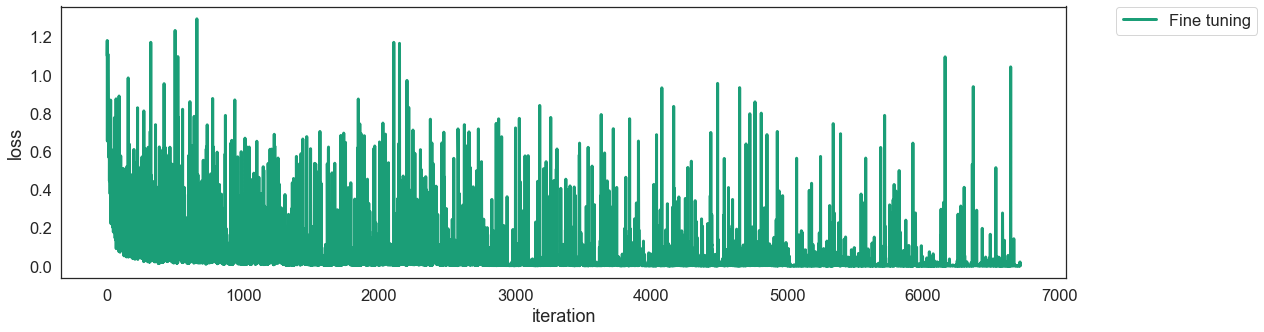

In [7]:
lossABTE = np.loadtxt('model_ABSA/losses_lr1e-05_epochs5_batch8.txt')
# lossABTE_AS = np.loadtxt('model_ABSA_adapter_scheduler/losses_lr1e-05_epochs5_batch8.txt')
# lossABTE_S = np.loadtxt('model_ABSA_scheduler/losses_lr1e-05_epochs5_batch8.txt')
# lossABTE_A = np.loadtxt('model_ABSA_adapter/losses_lr1e-05_epochs5_batch8.txt')

sns.set_theme (style="white", rc={"lines.linewidth": 3}, font_scale=1.5, palette="Dark2")
fig, ax = plt.subplots(figsize=(18,5))

sns.lineplot(range(len(lossABTE)), lossABTE, ax=ax, label = 'Fine tuning')
# sns.lineplot(range(len(lossABTE_S)), lossABTE_S, ax=ax, label = 'Fine tuning +\nscheduler')
# sns.lineplot(range(len(lossABTE_A)), lossABTE_A, ax=ax, label = 'Adapter')
# sns.lineplot(range(len(lossABTE_AS)), lossABTE_AS, ax=ax, label = 'Adapter +\nscheduler')

ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

if not os.path.isdir('results_ABSA'):
    os.makedirs('results_ABSA')

fig.savefig('results_ABSA/loss_lr{:.5f}_epochs{}_batch{}.pdf'.format(lr, epochs, batch), dpi=300, bbox_inches='tight')

### 3.b Classification reports

Here we propose the classification reports for all the four models trained in the previous sections and tested on test dataset.

Fine-tuning with scheduler and simple adapter show the same results, with high precision and recall for negative and positive aspects, but low recall for neutral aspects, which means that we have difficulties in predicting neutral aspects. Low recall for neutral aspects can be also highlighted in fine-tuning and adapter+scheduler.

In general, fine-tuning and adapter+scheduler exhibit lower values of precision/recall (f1-score) if compared with the other two. Therefore, we can conclude that fine-tuning with scheduler and simple adapter are the best models to identify negative and positive polarities, even though they have high proabability of failing in identifying neutral aspects.

These results could be easily understood, since the concept of "neutral aspect" is less clear than 'positive' and 'negative' polarities, also in a common spoken language. Moreover, if we think of possible applications of the provided architecture, we could argue that a possible customer of the model we build would be more interested in identifying negative and positive aspects, rather than neutral ones. As a consequence, we can conclude that even if it has limitations, the provided model can still be applied with good results to detect whether a sentence is positive or negative with respect to a certain aspect.

In [9]:
from utils import classification_report_read, print_aligned
test_ABSA = classification_report_read('model_ABSA/results/test_report_lr1e-05_epochs5_batch8.csv')
# test_ABSA_S = classification_report_read('model_ABSA_scheduler/results/test_report_lr1e-05_epochs5_batch8.csv')
# test_ABSA_A = classification_report_read('model_ABSA_adapter/results/test_report_lr1e-05_epochs5_batch8.csv')
# test_ABSA_AS = classification_report_read('model_ABSA_adapter_scheduler/results/test_report_lr1e-05_epochs5_batch8.csv')
print(test_ABSA, 'TEST FINE-TUNING')
# print_aligned(test_ABSA, test_ABSA_S, 'TEST FINE-TUNING', 'TEST FINE-TUNING+SCHEDULER')
# print_aligned(test_ABSA_A, test_ABSA_AS, 'TEST ADAPTER', 'TRAIN ADAPTER+SCHEDULER')

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
    positive       1.00      0.99      0.99        86

    accuracy                           0.99        86
   macro avg       0.50      0.49      0.50        86
weighted avg       1.00      0.99      0.99        86

 TEST FINE-TUNING


### 3.c Confusion matrix

Finally, let us go deeper in the analysis of the provided architecture by showing the confusion matrices for the four models.

The main observation is that all of the models show high rate of true positive for positive polarity. Moreover, the most problematic classification concerns the neutral aspect, which is likely misclassified as having positive polarity, and the misclassification of negatives as positives is also non negligible.

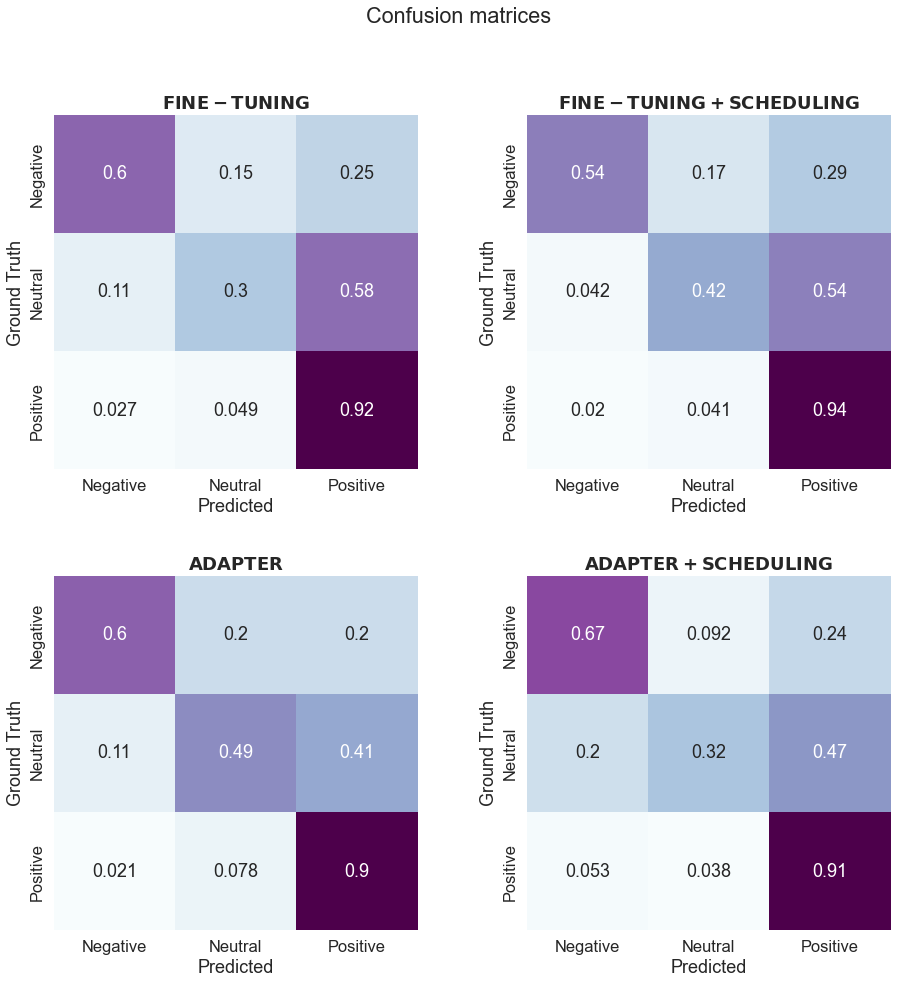

In [28]:
# confusion matrix
def plot_confusion_matrix(predictions, labels, title, ax,
                          cmap='BuPu'):
    """
    This function prints and plots the confusion matrix.
    """
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(labels, predictions, normalize = 'true')
    cm = cm[1:,1:]
    sns.set_theme (style="white", rc={"lines.linewidth": 3}, font_scale=1.5)
    sns.heatmap(cm, annot=True,  cmap=cmap, ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_yticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_ylabel('Ground Truth'),ax.set_xlabel('Predicted')

def plot_confusion_matrix_df(df_path, title, ax, cmap='BuPu'):

    df = pd.read_csv(df_path)
    pred = df['Predicted'].apply(lambda x: [int (i) if i !='None' else -2 for i in x.strip('][').split(', ')]).to_list()
    gtruth = df['Actual'].apply(lambda x: [int (i) if i !='None' else -2 for i in x.strip('][').split(', ')]).to_list()
    predicted, ground_truth = [], []
    for i in range(len(pred)):
        predicted+=pred[i]
        ground_truth+=gtruth[i]
    plot_confusion_matrix(predicted, ground_truth, title, ax, cmap=cmap)

def compare_confusion_mat():
    df = 'model_ABSA/results/test_pred_lr1e-05_epochs5_batch8.csv'
    dfS = 'model_ABSA_scheduler/results/test_pred_lr1e-05_epochs5_batch8.csv'
    dfA = 'model_ABSA_adapter/results/test_pred_lr1e-05_epochs5_batch8.csv'
    dfAS = 'model_ABSA_adapter_scheduler/results/test_pred_lr1e-05_epochs5_batch8.csv'
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    #set space between subplots
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    fig.suptitle('Confusion matrices')
    plot_confusion_matrix_df(df, r'$\bf{FINE-TUNING}$', ax[0][0])
    plot_confusion_matrix_df(dfS, r'$\bf{FINE-TUNING + SCHEDULING}$', ax[0][1])
    plot_confusion_matrix_df(dfA, r'$\bf{ADAPTER}$', ax[1][0])
    plot_confusion_matrix_df(dfAS, r'$\bf{ADAPTER + SCHEDULING}$', ax[1][1])

    fig.savefig('results_ABSA/CMatrix_test.png', dpi=300, bbox_inches='tight')

compare_confusion_mat()

### 3.d Results visualization

Finally, let us show how to use the provided model to predict the polarity of a sentence with respect to a specific aspect with any sentence. It is sufficient to call the method predict of the class ABSAModel. Examples as follow:


In [29]:
def predict_sentiment(review, aspect, model, model_path):
    x, y, z = modelABSA.predict(review, aspect, load_model=model_path)

    if y == 1:
        return 'The review "{}" \nw.r.t. the aspect "{}" is positive\n'.format(review, aspect)
    elif y == 0:
        return 'The review "{}" \nw.r.t. the aspect "{}" is neutral\n'.format(review, aspect)
    else:
        return 'The review "{}" \nw.r.t. the aspect "{}" is negative\n'.format(review, aspect)

In [30]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = 'model_ABSA_adapter_scheduler/model_lr1e-05_epochs4_batch8.pkl'
modelABSA = ABSAModel(tokenizer, adapter=True)

print (predict_sentiment("they make the BEST spice tuna roll in town, and the asian salad is ok", "tuna", modelABSA, model_path)+"\n")

print (predict_sentiment("the food is fantastic, but the prices were too high", "prices", modelABSA, model_path)+"\n")
print (predict_sentiment("the food is fantastic, but the prices were too high", "food", modelABSA, model_path)+"\n")

print (predict_sentiment("the chicken tastes like plastic, even tough they make the best ", "chicken", modelABSA, model_path)+"\n")

The review "they make the BEST spice tuna roll in town, and the asian salad is ok" 
w.r.t. the aspect "tuna" is positive


The review "the food is fantastic, but the prices were too high" 
w.r.t. the aspect "prices" is negative


The review "the food is fantastic, but the prices were too high" 
w.r.t. the aspect "food" is positive


The review "the chicken tastes like plastic, even tough they make the best " 
w.r.t. the aspect "chicken" is positive




#### Word clouds (adapter)

Finally, just to have an overview of which are the term words that can be associated with a certain feeling, we plot the word clouds both for negative and positive polarity, showing target vs predicted.
Note that, since reviews refer to different restaurants, the same words can be associated with two opposite feelings, e.g. the word 'food' will of course mark both a positive and a negative review.

POSITIVE ASPECTS


ValueError: Only supported for TrueType fonts

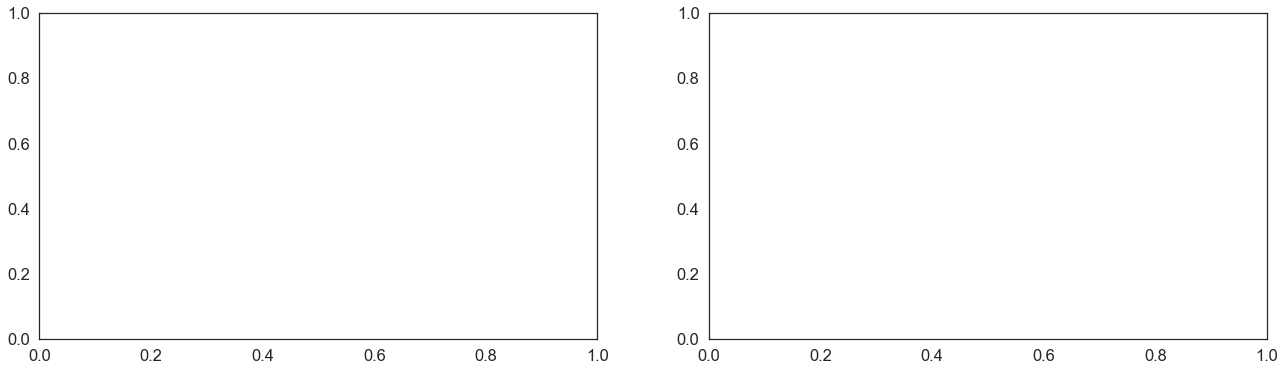

In [37]:
df_pred = pd.read_csv('model_ABSA_adapter/results/test_pred_lr1e-05_epochs5_batch8.csv')
from utils import target_predicted_wordcloud

def tokens_polarity (tokens, polarity_data):

    #string to list
    tokens = [t.strip('][').split(', ') for t in tokens]
    polarity_data = [p.strip('][').split(', ') for p in polarity_data]
    polarity_data = [[int(i) if i != 'None' else None for i in p] for p in polarity_data]
    positive = []
    negative = []
    neutral = []
    for p in polarity_data: #each p is a list
        for pp in p:
            t = tokens[polarity_data.index(p)][p.index(pp)][1:-1]
            if pp is not None:
                if pp == 1:
                    positive.append(t)
                elif pp == -1:
                    negative.append(t)
                elif pp == 0:
                    neutral.append(t)
    return positive, negative, neutral

pred_pos, pred_neg, pred_neut = tokens_polarity(df_pred['Tokens'].values, df_pred['Predicted'].values)
gold_pos, gold_neg, gold_neut = tokens_polarity(df_pred['Tokens'].values, df_pred['Actual'].values)

print ('POSITIVE ASPECTS')
target_predicted_wordcloud(' '.join(gold_pos), ' '.join(pred_pos), "results_ABSA/adapter_positive_wordcloud.pdf")

In [ ]:
print ('NEGATIVE ASPECTS')
target_predicted_wordcloud(' '.join(gold_neg), ' '.join(pred_neg), "results_ABSA/adapter_negative_wordcloud.pdf")

## 4. Conclusions and comparison with other results.

Let us now draw some conclusions with refer to the actual SemEval 2014 task [2].

The following table shows results for the aspect-term extraction task:

<p align="center">
  <img src="imgs/ate.png" width="300" />
</p>

Recall that our best model (adapter+scheduler) provides an average f1 score of 0.70 on the classification of an aspect-term, which is in the range of the other goups which partecipated to the SemEval.

Moreover, the following table shows the f1-score for the aspect-based sentiment analysis task, considering all the possible polarities for all the groups who partecipated to the task:

<p align="center">
  <img src="imgs/f1absa.png" width="180" />
</p>

If we consider neutral, positive and negative polarities, our best model (fine-tuning + scheduler and adapter) provides an average f1-score of 0.72, which is in the range.

## Aknowledgements

The general structure of the model (i.e. padding, dataset construction...) has been taken from [1], nevetheless we organized the model into a user-friendly class structure which provides a simple interface to the model. Moreover, we changed the optimization strategy, using AdamW instead of a generic Adam, introducing the learning rate scheduling and Adapter option as an alternative to fine-tuning.
Finally, we add a detailed analysis of the model performance, including the study of the training history, confusion matrix and visualization


## References:

[1] **Aspect-Term-Extraction-and-Analysis**, https://github.com/1tangerine1day/Aspect-Term-Extraction-and-Analysis

[2] Maria Pontiki, Dimitris Galanis, John Pavlopoulos, Harris Papageorgiou, Ion Androutsopoulos, and Suresh Manandhar. 2014. **SemEval-2014 Task 4: Aspect Based Sentiment Analysis.** In Proceedings of the 8th International Workshop on Semantic Evaluation (SemEval 2014), pages 27–35, Dublin, Ireland. Association for Computational Linguistics.

[3] Devlin, Jacob and Chang, Ming-Wei and Lee, Kenton and Toutanova, Kristina, **BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding**, DOI: 10.48550/ARXIV.1810.04805

[4] **HuggingFace BERT models**, https://huggingface.co/docs/transformers/model_doc/bert

[5] **AdapterHub: A Framework for Adapting Transformers**, Jonas Pfeiffer et al., Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP 2020): Systems Demonstrations, https://www.aclweb.org/anthology/2020.emnlp-demos.7

[6] Houlsby, Neil and Giurgiu, Andrei and Jastrzebski, Stanislaw and Morrone, Bruna and de Laroussilhe, Quentin and Gesmundo, Andrea and Attariyan, Mona and Gelly, Sylvain, **Parameter-Efficient Transfer Learning for NLP**, DOI: 10.48550/ARXIV.1902.00751

[7] Loshchilov Ilya, Hutter Frank, **Decoupled Weight Decay Regularization**, DOI: 10.48550/ARXIV.1711.05101

[8] PyTorch: An Imperative Style, High-Performance Deep Learning Library}, Paszke Adam,  Gross Sam, Massa Francisco, Lerer Adamm, Bradbury James, Chanan Gregory, Killeen Trevor, Lin Zeming, Gimelshein Natalia, Antiga Luca, Desmaison Alban, Kopf Andreas, Yang Edward, DeVit Zachary, Raison Martin, Tejani Alykhan, Chilamkurthy Sasank, Steiner Benoit, Fang Lu, Bai Junjie, Chintala Soumith, http://papers.neurips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library.pdf
